In [1]:
import sys
sys.path.append('/home/user/Downloads/ASK Project/vggish-tensorflow1-default-v1')

In [1]:
import os
import numpy as np
import librosa
import tensorflow as tf
from concurrent.futures import ThreadPoolExecutor, as_completed
import vggish_input, vggish_params, vggish_slim

# Updated Feature Extraction
# Includes delta and delta-delta MFCCs and optimized VGGish embeddings
def extract_features(audio, sr=16000, vggish_model=None):
    # Extract MFCCs, delta, and delta-delta coefficients
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    delta_mfccs = librosa.feature.delta(mfccs)
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    mfcc_features = np.vstack((mfccs, delta_mfccs, delta2_mfccs)).T

    # Ensure consistent length by padding or truncating
    min_length = 100
    if mfcc_features.shape[0] < min_length:
        mfcc_features = np.pad(mfcc_features, ((0, min_length - mfcc_features.shape[0]), (0, 0)), mode='constant')
    else:
        mfcc_features = mfcc_features[:min_length, :]

    # Extract VGGish embeddings
    vggish_features = extract_vggish_features(audio, sr, vggish_model)
    if vggish_features is None:
        return None

    # Concatenate MFCCs and VGGish embeddings
    combined_features = np.hstack((mfcc_features, vggish_features))
    return combined_features

def extract_vggish_features(audio, sr, vggish_model):
    try:
        infer = vggish_model.signatures['serving_default']
        examples = vggish_input.waveform_to_examples(audio, sr)
        embedding = infer(input_tensor=tf.convert_to_tensor(examples, dtype=tf.float32))['embedding']
        embedding_resized = np.resize(embedding.numpy(), (100, embedding.shape[1]))
        return embedding_resized
    except Exception as e:
        print(f"Error extracting VGGish embeddings: {e}")
        return None

In [ ]:
def extract_label(filename):
    parts = filename.split('-')
    return int(parts[2]) - 1

def load_single_file(file_path, sr=16000, vggish_model=None):
    try:
        audio, _ = librosa.load(file_path, sr=sr)
        features = extract_features(audio, sr, vggish_model)
        if features is not None:
            label = extract_label(os.path.basename(file_path))
            return features, label
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
    return None, None

def load_data(input_dir, vggish_model_path= r"C:\Users\USER\Documents\Emotion Recognition from Voice\Pre-Trained Models\vggish_saved_model", sr=16000):
    X, y = [], []
    file_paths = [
        os.path.join(root, file)
        for root, _, files in os.walk(input_dir)
        for file in files if file.endswith('.wav')
    ]
    vggish_model = tf.saved_model.load(vggish_model_path)
    with ThreadPoolExecutor(max_workers=4) as executor:
        future_to_file = {executor.submit(load_single_file, path, sr, vggish_model): path for path in file_paths}
        for future in as_completed(future_to_file):
            features, label = future.result()
            if features is not None and label is not None:
                X.append(features)
                y.append(label)
    return np.array(X), np.array(y)

In [2]:
import os 
import numpy as np

X_file = 'X_data_Augmented Balanced RAVDESS 2.npy' 
y_file = 'y_data_Augmented Balanced RAVDESS 2.npy' 
if not os.path.exists(X_file) or not os.path.exists(y_file): 
    X, y = load_data('/home/user/Downloads/ASK Project/Augmented Balanced RAVDESS') 
    np.save(X_file, X) 
    np.save(y_file, y) 
else: 
    X = np.load(X_file) 
    y = np.load(y_file)

In [3]:
# Optimized Transformer Model
def build_transformer_model(input_shape, num_classes):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=64)(inputs, inputs)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.models.Model(inputs, outputs)


# Train/Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and Compile Model
input_shape = X.shape[1:]
num_classes = len(np.unique(y))
model = build_transformer_model(input_shape, num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
# Class Weights and Callbacks
from sklearn.utils.class_weight import compute_class_weight
class_weights = dict(enumerate(compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)))
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Train Model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
import numpy as np

class PositionalEncoding(Layer):
    def __init__(self, position, d_model, **kwargs):
        # Use kwargs to handle additional arguments like 'trainable'
        super(PositionalEncoding, self).__init__(**kwargs)
        self.position = position
        self.d_model = d_model
        self.positional_encoding = self.get_positional_encoding()

    def get_positional_encoding(self):
        angle_rads = self._get_angles(
            np.arange(self.position)[:, np.newaxis],
            np.arange(self.d_model)[np.newaxis, :],
            self.d_model,
        )
        # Apply sin to even indices and cos to odd indices
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        return tf.constant(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def _get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_rates

    def call(self, inputs):
        return inputs + self.positional_encoding[:, :tf.shape(inputs)[1], :]

    # Add this method to allow proper serialization and deserialization
    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            "position": self.position,
            "d_model": self.d_model,
        })
        return config

In [ ]:

# Build Improved Transformer Model
def build_improved_transformer_model(input_shape, num_classes):
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Positional Encoding
    x = PositionalEncoding(position=input_shape[0], d_model=input_shape[1])(inputs)
    
    # Multi-Head Attention
    x = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=input_shape[1])(x, x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    
    # Feedforward Layer
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    
    # Global Average Pooling
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    
    # Classification Layers
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    return tf.keras.models.Model(inputs, outputs)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Model Parameters
input_shape = X.shape[1:]  # Ensure this matches the shape of your input data
num_classes = len(np.unique(y))  # Number of unique classes in your dataset

# Build the model
model = build_improved_transformer_model(input_shape, num_classes)

# Compile Model with AdamW optimizer
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',  # Use sparse if your labels are integers
              metrics=['accuracy'])

# Compute Class Weights
class_weights = dict(enumerate(compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)))


# Callbacks for Training
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_transformer_model.keras", save_best_only=True, monitor='val_loss', verbose=1)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)


In [ ]:
# Train Model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    callbacks=[lr_scheduler, early_stopping, checkpoint, tensorboard],
    verbose=1
)

202/202 ━━━━━━━━━━━━━━━━━━━━ 14s 68ms/step
Test Accuracy: 0.87


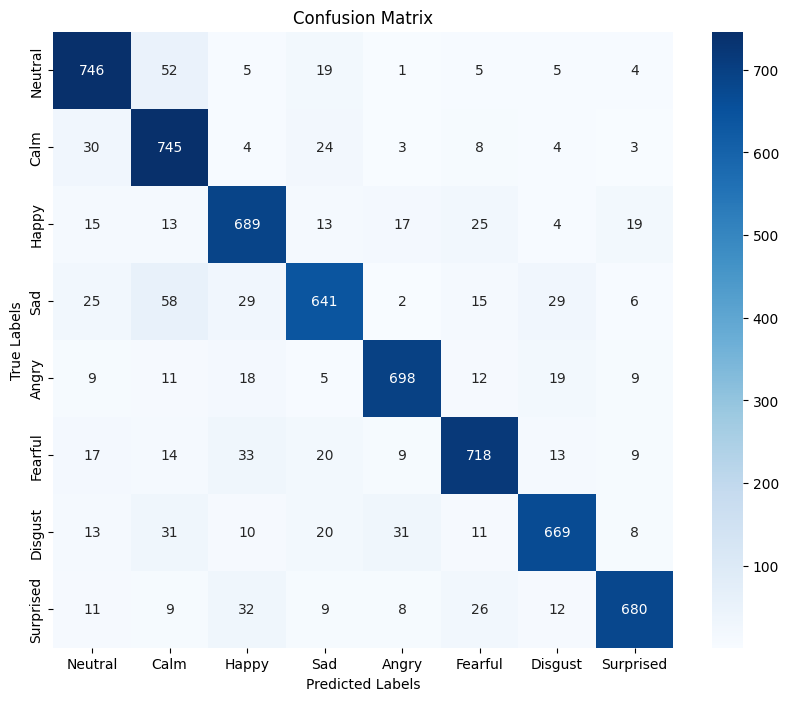

Classification Report:
               precision    recall  f1-score   support

     Neutral       0.86      0.89      0.88       837
        Calm       0.80      0.91      0.85       821
       Happy       0.84      0.87      0.85       795
         Sad       0.85      0.80      0.82       805
       Angry       0.91      0.89      0.90       781
     Fearful       0.88      0.86      0.87       833
     Disgust       0.89      0.84      0.86       793
   Surprised       0.92      0.86      0.89       787

    accuracy                           0.87      6452
   macro avg       0.87      0.87      0.87      6452
weighted avg       0.87      0.87      0.87      6452



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
import numpy as np
import tensorflow as tf

model = tf.keras.models.load_model(r"C:\Users\USER\Documents\Emotion Recognition from Voice\emotion-recognition-model-2-other-default-v1\best_emotion_model_87.h5",custom_objects={'PositionalEncoding': PositionalEncoding})
#model = tf.keras.models.load_model(r'C:\Users\USER\Documents\ASK Project\emotion-recognition-model-1-other-default-v1\emotion_recognition_model_80.h5')
# Make predictions
y_pred_probs = model.predict(X_test)  # Predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted class labels

# Calculate test accuracy
if len(y_test.shape) == 1:  # If y_test is not one-hot encoded
    test_accuracy = accuracy_score(y_test, y_pred)
else:  # If y_test is one-hot encoded
    test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Generate confusion matrix
emotion_labels = ['Neutral', 'Calm', 'Happy', 'Sad', 'Angry', 'Fearful', 'Disgust', 'Surprised']  # Adjust as per your dataset
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification report
report = classification_report(y_test, y_pred, target_names=emotion_labels)
print("Classification Report:\n", report)

# Plot ROC curve for each class (if y_test is one-hot encoded)
if len(y_test.shape) > 1 and y_test.shape[1] > 1:  # Check for one-hot encoding
    plt.figure(figsize=(10, 8))
    for i in range(len(emotion_labels)):
        fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{emotion_labels[i]} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

In [7]:
import whisper
whisper_model = whisper.load_model("base")

c:\Users\USER\anaconda3\Lib\site-packages\whisper\__init__.py:69: UserWarning: C:\Users\USER\.cache\whisper\base.pt exists, but the SHA256 checksum does not match; re-downloading the file
  warnings.warn(
100%|███████████████████████████████████████| 139M/139M [01:14<00:00, 1.95MiB/s]


RuntimeError: Model has been downloaded but the SHA256 checksum does not not match. Please retry loading the model.

In [6]:
%pip install openai-whisper

  Using cached openai-whisper-20240930.tar.gz (800 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/883.8 kB ? eta -:--:--
   ---------------------------------------- 0.0/883.8 kB ? eta -:--:--
    --------------------------------------- 20.5/883.8 kB ? eta -:--:--
   - ------------------------------------- 30.7/883.8 kB 660.6 kB/s eta 0:00:02
   -- ------------------------------------ 61.4/883.8 kB 656.4 kB/s eta 0:00:02
   ---- --------------------------------- 112.6/883.8 kB 819.2 kB/s eta 0:00:01
   ----- -------------------------------- 122.9/883.8 kB 798.9 kB/s eta 0:00:01
   -------- ----------------------------- 194.6/883.8 kB 841.6 kB/s eta 0:00:01
 

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
